# Example usage

Here we demonstrate how to use `scmrelax` package to construct the counterfactual of the treated unit using relaxed balancing estimators.

we examine the impact of the 2016 Brexit referendum on the United Kingdom’s GDP. On June 23, 2016, a referendum on the UK’s membership in the European
Union resulted in 51.89% of voters favoring departure, triggering a withdrawal process that concluded on January 31, 2020. The referendum’s outcome was largely unexpected by markets. It prompts us to designate the third quarter of 2016 as the starting point for analyzing its effects. 

We estimate the combination weights using YOY growth rate of quarterly GDP by 1. synthetic control (SCM), 2. EL-SCM-relaxation, 3. Entropy-SCM-relaxation, 4. $L_2$-SCM-relaxtion. Then we use the esimated weights to construct the counterfactual GDP growth rate.


## Setup and imports

In [1]:
import scmrelax

print(scmrelax.__version__)

0.1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd

# Set plotting style
plt.style.use('seaborn-v0_8-paper')
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Suppress warnings
warnings.filterwarnings("ignore")

## Data preprocessing
The processed_GDP.csv can be found in the folder.

In [3]:
# Read the preprocessed data
GDP = pd.read_csv('processed_GDP_data.csv', index_col=0, parse_dates=True)

# Calculate GDP growth rate
GDP_growth = 100*GDP.pct_change(4).dropna()

# Define the function to prepare the data
def prepare_data(GDP_growth, target_country, pre_treat_date):
    """Prepare data for synthetic control analysis."""
    y = GDP_growth[target_country]
    X = GDP_growth.drop(target_country, axis=1)
    
    y_pre = y.loc[:pre_treat_date]
    X_pre = X.loc[:pre_treat_date]
    country_list = X_pre.columns
    
    return (y.to_numpy(), X.to_numpy(), 
            y_pre.to_numpy(), X_pre.to_numpy(), 
            country_list)

# Prepare data for analysis
target_country = 'United Kingdom'
pre_treat_q = '2016-06-30'
treat_q = '2016-09-30'

y, X, y_pre, X_pre, country_list = prepare_data(
    GDP_growth, target_country, pre_treat_q
)

# print the sample size and the size of the donor pool
print("(Pre-treatment periods, Donor pool size): ", X_pre.shape)

(Pre-treatment periods, Donor pool size):  (51, 57)


## Estimate the weights and construct the counterfactual growth rates

In [4]:
results = scmrelax.fit(X_pre, y_pre, X)

## Evaluate the in-sample empirical risks

In [5]:
# Calculate in-sample error rates
treatment_time = y_pre.shape[0]
ER_scm = np.mean((results['scm']['predictions'][:treatment_time] - y_pre)**2)
ER_EL = np.mean((results['EL']['predictions'][:treatment_time] - y_pre)**2)
ER_entropy = np.mean((results['entropy']['predictions'][:treatment_time] - y_pre)**2)
ER_l2 = np.mean((results['l2']['predictions'][:treatment_time] - y_pre)**2)

print("In-sample Empirical Risks:")
print(f"SCM: {ER_scm:.4f}")
print(f"EL-SCM-Relaxation: {ER_EL:.4f}")
print(f"Entropy-SCM-Relaxation: {ER_entropy:.4f}")
print(f"L2-SCM-Relaxation: {ER_l2:.4f}")

In-sample Empirical Risks:
SCM: 0.6822
EL-SCM-Relaxation: 1.4765
Entropy-SCM-Relaxation: 1.2837
L2-SCM-Relaxation: 1.1798


## Plot the gap between realized growth rate and fitted growth rate

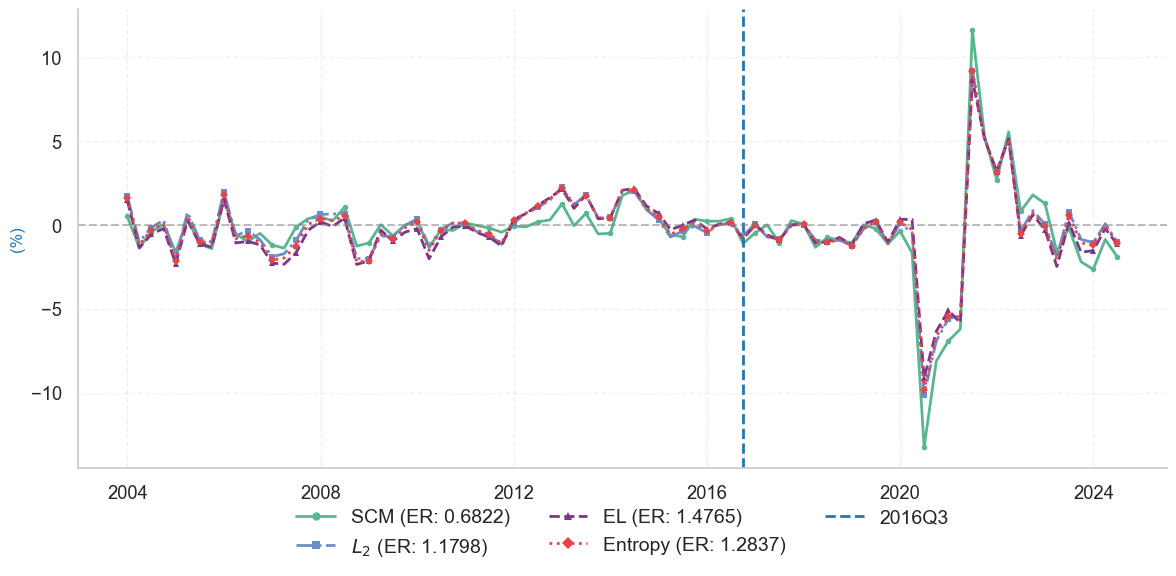

In [6]:
# define some colors
color_SCM = '#59B78F'
color_L2 = '#6A8EC9'
color_EL = '#7A378A'
color_entropy = '#E84446'
color_real = '#1f77b4'
color_treatment = '#1f77b4'

# Convert to time series
y = pd.Series(y, index=GDP_growth.index)
y_fit_scm = pd.Series(results['scm']['predictions'], index=GDP_growth.index)
y_fit_EL = pd.Series(results['EL']['predictions'], index=GDP_growth.index)
y_fit_entropy = pd.Series(results['entropy']['predictions'], index=GDP_growth.index)
y_fit_l2 = pd.Series(results['l2']['predictions'], index=GDP_growth.index)

# Create figure with style guide settings
plt.figure(figsize=(12, 6))

# Plot all differences with enhanced distinction
# SCM: solid line with markers
plt.plot(y-y_fit_scm, color=color_SCM, label=f'SCM (ER: {round(ER_scm, 4)})', 
         linewidth=2, linestyle='-', marker='o', markersize=4, markevery=2)

# L2: dash-dot line with squares
plt.plot(y-y_fit_l2, color=color_L2, label=f'$L_2$ (ER: {round(ER_l2, 4)})', 
         linewidth=2, linestyle='-.', marker='s', markersize=4, markevery=2)

# EL: dashed line with triangles
plt.plot(y-y_fit_EL, color=color_EL, label=f'EL (ER: {round(ER_EL, 4)})', 
         linewidth=2, linestyle='--', marker='^', markersize=4, markevery=2)

# Entropy: dotted line with diamonds
plt.plot(y-y_fit_entropy, color=color_entropy, label=f'Entropy (ER: {round(ER_entropy, 4)})', 
         linewidth=2, linestyle=':', marker='D', markersize=4, markevery=2)


# Add y-axis label
plt.ylabel('(%)', fontsize=12, color = '#1f77b4')

# Add treatment line
treatment_date = GDP_growth.index[treatment_time]
plt.axvline(x=treatment_date, color=color_treatment, linestyle='--', label='2016Q3', linewidth=2)

# Add zero line
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.5)

# Add legend with enhanced visibility
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    fontsize=14,
    frameon=True,
    facecolor='white',
    edgecolor='none',
    markerscale=1.5  # Make markers larger in legend
)

# Add grid with reduced opacity
plt.grid(True, linestyle='--', alpha=0.3)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()
